# Deep Ensembles for Classification

## Paper | Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles

### Installations

In [ ]:
# ! pip install --quiet "torchvision" "torch>=1.6, <1.9" "pytorch-lightning>=1.3" "torchmetrics>=0.3"

In [ ]:
# ! pip install wandb

In [ ]:
# import wandb
# ! wandb login

### Imports

In [1]:
from typing import Optional
from copy import deepcopy

import numpy as np

import torch as T
from torch.utils.data import random_split, DataLoader
from torchmetrics import Accuracy

import torchvision as TV
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning import loggers as pl_loggers


import matplotlib.pyplot as plt

nn = T.nn
F = nn.functional

## Utile's

In [2]:
def plot_pred_entropy_hist(entropy, title=''):
    """
    Inspired by https://github.com/google/uncertainty-baselines
    """
    fig = plt.figure(figsize=(6,4), dpi=120)
    with plt.style.context('seaborn-whitegrid'):
        ax = plt.gca()
        
        ax.plot(entropy['slots'][:-1], np.array(entropy['n_examples']))
        ax.set_xlabel("Entropy")
        ax.set_ylabel("# Examples")
        ax.set_title(title)

In [3]:
def plot_pred_entropy_hist_two(ENTROPY, title=''):
    """
    Inspired by https://github.com/google/uncertainty-baselines
    """
    fig = plt.figure(figsize=(6,4), dpi=120)
    with plt.style.context('seaborn-whitegrid'):
        ax = plt.gca()
        data_type = ['iid', 'ood']
        line_type = ['-', '--']
        for i in range(2):
            entropy = ENTROPY[i]
            ax.plot(entropy['slots'][:-1], np.array(entropy['n_examples']), label=data_type[i])
        ax.set_xlabel("Entropy")
        ax.set_ylabel("# Examples")
        ax.set_title(title)
        ax.legend()

In [4]:
def plot_pred_entropy_hist_multi(INFO, title=''):
    plt.rcParams['font.size'] = '16'
    with plt.style.context('seaborn-whitegrid'):
        fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(16,12))
        fig.text(0.5, 0.95, 'Predictive Entropy MNIST', ha='center', fontweight="bold", size=20)
        fig.text(0.5, 0.075, 'Entropy Values', ha='center', size=20)
        fig.text(0.05, 0.5, '# Examples', va='center', rotation='vertical', size=20)
        plt.setp(axs, xticks=np.arange(-0.5, 2.0, 0.5))
        
        # Data Type
        axs[0,0].set_ylabel("I.I.D.", size=18)
        axs[1,0].set_ylabel("O.O.D.", size=18)
        
        # Model Type
        axs[0,0].set_title("Ensemble", size=20)
        axs[0,1].set_title("Ensemble+AT", size=20)
        axs[0,2].set_title("MC Dropout", size=20)
        
        # Predictive Entropy
        data_type = ['iid', 'ood']
        model_type = ['Ensemble', 'Ensemble+AT', 'MC Dropot']
        sub_model_type = ['1', '5', '10']
        
        for i in range(2): # data_type
            for j in range(3): # model_type
                for k in range(3): # sub_model_type
                    entropy = INFO[ data_type[i] ][ model_type[j] ][ sub_model_type[k] ][ 'entropy' ]
                    axs[i,j].plot(entropy['slots'][:-1], np.array(entropy['n_examples']), label=sub_model_type[k])
                    axs[i,j].legend()

In [5]:
def plot_reliability(reliability, color='', title=''):
    fig = plt.figure(figsize=(6,4), dpi=120)
    with plt.style.context('seaborn-whitegrid'):
        ax = plt.gca()

        ax.plot(reliability['confidence'], np.array(reliability['accuracy']), color)
        ax.set_xlabel("Confidence")
        ax.set_ylabel("Accuracy")
        ax.set_xlim([0, 0.9])
        ax.set_ylim([0, 0.9])
        ax.set_title(title)

In [6]:
def plot_reliability_multi(INFO, title=''):
    fig = plt.figure(figsize=(6,4), dpi=120)
    with plt.style.context('seaborn-whitegrid'):
        ax = plt.gca()
        
        model_type = ['Ensemble', 'Ensemble+AT', 'MC Dropot']
        for j in range(3):
            reliability = INFO[ 'mix' ][ model_type[j] ][ '10' ][ 'reliability' ]
            ax.plot(reliability['confidence'], np.array(reliability['accuracy']), label=model_type[j])
        ax.legend()
        ax.set_xlabel("Confidence Threshold")
        ax.set_ylabel("Accuracy")
        ax.set_xlim([0, 0.9])
        ax.set_ylim([0, 0.9])
        ax.set_title(title)

### Hyperparametrs

In [7]:
input_size = 28*28
n_classes = 10 # iid: 0-4 | ood: 5-9
net_arch = [200, 200, 200] # layers, hidden_units
batch_size = 100
learning_rate = 0.035 # After many trials :")
epsilon = 0.01
activation = 'ReLU'
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

### DataLoaders for MNISTD

In [8]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./data"):
        super().__init__()
        self.data_dir = data_dir
        self.mode = None
#         self.transform = transforms.Compose([transforms.ToTensor()])

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=False)
        MNIST(self.data_dir, train=False, download=False)

    def setup(self, stage: Optional[str] = None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=transforms.ToTensor())
            
            if self.mode == 'iid':
                idx0 = T.tensor(mnist_full.targets)==0
                idx1 = T.tensor(mnist_full.targets)==1
                idx2 = T.tensor(mnist_full.targets)==2
                idx3 = T.tensor(mnist_full.targets)==3
                idx4 = T.tensor(mnist_full.targets)==4
                idx = T.logical_or(idx0, T.logical_or(idx1,  T.logical_or(idx2,  T.logical_or(idx3, idx4))))
                mnist_full.targets = mnist_full.targets[idx]
                mnist_full.data = mnist_full.data[idx]
            elif self.mode == 'ood': # we don't use that in training
                pass
            
            train = int(0.9*len(mnist_full))
            val = len(mnist_full) - train
            self.mnist_train, self.mnist_val = random_split(mnist_full, [train, val])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            mnist_test = MNIST(self.data_dir, train=False, transform=transforms.ToTensor())
            
            if self.mode == 'iid':
                idx0 = T.tensor(mnist_test.targets)==0
                idx1 = T.tensor(mnist_test.targets)==1
                idx2 = T.tensor(mnist_test.targets)==2
                idx3 = T.tensor(mnist_test.targets)==3
                idx4 = T.tensor(mnist_test.targets)==4
                idx = T.logical_or(idx0, T.logical_or(idx1,  T.logical_or(idx2,  T.logical_or(idx3, idx4))))
                mnist_test.targets = mnist_test.targets[idx]
                mnist_test.data = mnist_test.data[idx]
            elif self.mode == 'ood':
                idx5 = T.tensor(mnist_test.targets)==5
                idx6 = T.tensor(mnist_test.targets)==6
                idx7 = T.tensor(mnist_test.targets)==7
                idx8 = T.tensor(mnist_test.targets)==8
                idx9 = T.tensor(mnist_test.targets)==9
                idx = T.logical_or(idx5, T.logical_or(idx6,  T.logical_or(idx7,  T.logical_or(idx8, idx9))))
                mnist_test.targets = mnist_test.targets[idx]
                mnist_test.data = mnist_test.data[idx]
            
            self.mnist_test = mnist_test

        if stage == "predict" or stage is None:
            mnist_predict = MNIST(self.data_dir, train=False, transform=transforms.ToTensor())
            
            if self.mode == 'iid':
                idx0 = T.tensor(mnist_predict.targets)==0
                idx1 = T.tensor(mnist_predict.targets)==1
                idx2 = T.tensor(mnist_predict.targets)==2
                idx3 = T.tensor(mnist_predict.targets)==3
                idx4 = T.tensor(mnist_predict.targets)==4
                idx = T.logical_or(idx0, T.logical_or(idx1,  T.logical_or(idx2,  T.logical_or(idx3, idx4))))
                mnist_predict.targets = mnist_predict.targets[idx]
                mnist_predict.data = mnist_predict.data[idx]
            elif self.mode == 'ood':
                idx5 = T.tensor(mnist_predict.targets)==5
                idx6 = T.tensor(mnist_predict.targets)==6
                idx7 = T.tensor(mnist_predict.targets)==7
                idx8 = T.tensor(mnist_predict.targets)==8
                idx9 = T.tensor(mnist_predict.targets)==9
                idx = T.logical_or(idx5, T.logical_or(idx6,  T.logical_or(idx7,  T.logical_or(idx8, idx9))))
                mnist_predict.targets = mnist_predict.targets[idx]
                mnist_predict.data = mnist_predict.data[idx]
            
            self.mnist_predict = mnist_predict

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=batch_size, num_workers=4, shuffle=False)
    
    def adv_train_dataloader(self):
        self.train_dataloader()
        subset_inx = np.random.randint(len(self.mnist_train), size=3000)
        subset = T.utils.data.Subset(self.mnist_train, subset_inx)
        return DataLoader(subset, batch_size=batch_size, num_workers=4, shuffle=False)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=batch_size, num_workers=4, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=len(self.mnist_test), num_workers=4, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.mnist_predict, batch_size=batch_size, num_workers=4, shuffle=False)


In [9]:
mnist_dm = MNISTDataModule()
mnist_dm_iid = MNISTDataModule()
mnist_dm_iid.mode = 'iid'
mnist_dm_ood = MNISTDataModule()
mnist_dm_ood.mode = 'ood'

### Adversarial Attack | Fast Gradient Sign Method (FGSM)

In [10]:
def FGSM(X, Y, model, loss, epsilon=0.01):
    """
    Inspired by 
    https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial10/Adversarial_Attacks.html
    """
    _X = X.clone().requires_grad_()
    logits = model(_X.to(X.device))
    loss = loss(logits, Y)
    loss.sum().backward()
    noise_grad = T.sign(_X.grad.to(X.device))
    X_adv = X + epsilon * noise_grad
    return X_adv.detach_()

## Deep Models

In [11]:
class Model(LightningModule): # Deep Model
    def __init__(self, input_size, n_classes, net_arch, lr,
                 pl_logger=None, adv_train=False):
        super(Model, self).__init__()

        self.lr = lr

        if len(net_arch) > 0:
            layers = [nn.Linear(input_size, net_arch[0]), eval('nn.' + activation)()]
            for l in range(len(net_arch)-1):
                layers.extend([nn.Linear(net_arch[l], net_arch[l+1]), eval('nn.' + activation)()])
            if n_classes > 0:
                last_dim = net_arch[-1]
                layers.extend([nn.Linear(last_dim, n_classes), eval('nn.Identity')()])
        else:
            raise 'No network arch!'
            
        self.model = nn.Sequential(*layers)
#         self.loss = F.cross_entropy
        self.loss = F.nll_loss
        self.accuracy = Accuracy()
        self.adv_train = adv_train
        self.pl_logger = pl_logger
        self.LOGS = dict()
        self.INFO = dict()
    
    
    def forward(self, x, return_log_prob=True):
        logits = self.model(x)
        prob = F.softmax(logits, dim=1)
        log_prob = F.log_softmax(logits, dim=1)
        
        if return_log_prob:
            return prob, log_prob
        else:
            return prob
    
    
    def train_Model(self, data_module, n_epochs, trainer=None):
        if trainer:
            self.trainer = trainer
        else:
            self.trainer = Trainer(max_epochs=n_epochs,
#                                    gpus=1,
                                   enable_model_summary=False,
                                   checkpoint_callback=False,
                                   progress_bar_refresh_rate=20,
#                                    log_save_interval=100,
#                                    logger=self.pl_logger
#                                    callbacks=[checkpoint_callback],
                                 )
        
        self.data_module = data_module
        self.trainer.fit(self, data_module)
    
    
    def training_step(self, batch, batch_idx):
        X, Y = batch
        X_flat = X.reshape(-1, 28*28)
        prob, log_prob = self(X_flat)
        loss = self.loss(log_prob, Y)
        self.log("train_loss_nll", loss, prog_bar=True) 
        preds = T.argmax(log_prob, dim=1)
        self.accuracy(preds, Y)
        self.log("train_acc", self.accuracy, prog_bar=True)
        return loss
    
    
    def training_epoch_end(self, outputs):
        if self.adv_train:
            for batch_idx, batch in enumerate(self.data_module.adv_train_dataloader()):
                self.adv_training_step(batch, batch_idx)
            
            
    def adv_training_step(self, batch, batch_idx):
        X, Y = batch
        X, Y = X.to(self.device), Y.to(self.device)
        X_flat = X.reshape(-1, 28*28)
        X_adv_flat = FGSM(X_flat, Y, self.model, self.loss)
        
        self.optimizer.zero_grad()
        prob, log_prob = self(X_flat)
        prob_adv, log_prob_adv = self(X_adv_flat)
        loss = self.loss(log_prob, Y) + self.loss(log_prob_adv, Y)
        self.log("adv_loss", loss, prog_bar=True) 
        loss.backward()
        self.optimizer.step()
    
    def validation_step(self, batch, batch_idx):
        X, Y = batch
        X_flat = X.reshape(-1, 28*28)
        prob, log_prob = self(X_flat)
        loss = self.loss(log_prob, Y)
        self.log("val_loss_nll", loss, prog_bar=True) 
        preds = T.argmax(log_prob, dim=1)
        self.accuracy(preds, Y)
        self.log("val_acc", self.accuracy, prog_bar=True)
        
    def test_Model(self, data_module, entropy=False, reliability=False):
        self.entropy = entropy
        self.reliability = reliability
        self.trainer.test(self, data_module)
        return deepcopy(self.INFO)
    
    def test_step(self, batch, batch_idx):
        X, Y = batch
        X_flat = X.reshape(-1, 28*28)
        prob, log_prob = self(X_flat)
        
        loss_ce = F.cross_entropy(log_prob, Y)
        loss_nll = F.nll_loss(log_prob, Y)
        self.INFO['test_loss_ce'] = loss_ce
        self.INFO['test_loss_nll'] = loss_nll
        self.log("test_loss_ce", loss_ce)
        self.log("test_loss_nll", loss_nll)
        
        preds = T.argmax(log_prob, dim=1)
        accuracy = self.accuracy(preds, Y)
        self.INFO['test_acc'] = accuracy
        self.log("test_acc", accuracy)
        
        if self.entropy: self.calc_entropy(prob, log_prob)
        if self.reliability: self.calc_reliability(prob, preds, Y)
            
            
    # Tasks
    def calc_entropy(self, prob, log_prob):
        entropy = -np.sum((prob*log_prob).cpu().numpy(), axis=1)
        mean_entropy = entropy.mean()
        
        entropy_slots = np.arange(-0.2, 2.3, 0.1)
        n_examples = []
        
        for i in range(len(entropy_slots)-1):
            example = np.sum(
                np.logical_and(entropy>=entropy_slots[i],
                               entropy<entropy_slots[i+1])
                            )
            n_examples.append(example)
        
        self.INFO['entropy'] = dict()
#         self.INFO['entropy']['predictive'] = entropy
        self.INFO['entropy']['slots'] = entropy_slots
        self.INFO['entropy']['n_examples'] = n_examples
        self.INFO['entropy']['mean'] = mean_entropy
        self.log("mean_entropy", mean_entropy)
        
        
    def calc_reliability(self, prob, preds, Y):
        prob_np = prob.cpu().numpy()
        confidence_range = np.arange(0, 1, 0.1)
        acc_list = []
        
        for i in confidence_range:
            inx = np.argwhere(
                np.logical_and(i<=prob_np.max(axis=1),
                               prob_np.max(axis=1)<(i+0.1))).reshape(1,-1)[0]
            inx = T.tensor(inx, dtype=T.long)
            if len(inx) > 0:
                acc = self.accuracy(preds[inx].reshape(1,-1)[0],
                                    Y[inx].reshape(1,-1)[0]).cpu().numpy()
            else:
                acc = np.array(0.0)
            acc_list.append(acc)
            
        self.INFO['reliability'] = dict()
        self.INFO['reliability']['accuracy'] = acc_list
        self.INFO['reliability']['confidence'] = confidence_range
        
        
    def configure_optimizers(self):
        self.optimizer = T.optim.Adam(self.parameters(), lr=self.lr)
        return self.optimizer


In [12]:
class DEModel(LightningModule): # Deep Ensembles Model
    def __init__(self, n_models, input_size, n_classes, net_arch, lr,
                 pl_logger=None, adv_train=False, device='cpu', seed=0):
        super(DEModel, self).__init__()
        
        T.manual_seed(seed)
        self.accuracy = Accuracy()
        self.pl_logger = pl_logger
        self.LOGS = dict()
        self.INFO = dict()
        self._device_ = device #'cuda:0'
        
        self.n_models = n_models
        self.models = []
        for m in range(self.n_models):
            model = Model(input_size, n_classes, net_arch, lr, pl_logger, adv_train).to(device)
            self.models.append(model)
    
    
    def forward(self, x, sample_type='Average'):
        models_probs = [model(x, return_log_prob=False) for model in self.models]
        if sample_type=='Average':
            prob = (sum(models_probs) / self.n_models) + 1e-12 # bc 'T.log()' is unstable :(
            log_prob = T.log(prob)
        return prob, log_prob
    
    
    def train_Model(self, data_module, n_epochs):
        self.trainer = Trainer(max_epochs=n_epochs,
#                                gpus=1,
                               enable_model_summary=False,
                               checkpoint_callback=False,
                               progress_bar_refresh_rate=20,
#                                log_save_interval=100,
#                                logger=self.pl_logger
#                                callbacks=[checkpoint_callback],
                                 )
        for m in range(self.n_models):
            self.models[m].train_Model(data_module, n_epochs, self.trainer)
    
    
    def test_Model(self, data_module, entropy=False, reliability=False):
        self.entropy = entropy
        self.reliability = reliability
        self.models = [ model.to(self._device_) for model in self.models ]
        self.trainer.test(self, data_module)
        return deepcopy(self.INFO)
        
        
    def test_step(self, batch, batch_idx):
        X, Y = batch
        X_flat = X.reshape(-1, 28*28)
        prob, log_prob = self(X_flat)
        
        loss_ce = F.cross_entropy(log_prob, Y)
        loss_nll = F.nll_loss(log_prob, Y)
        self.INFO['test_loss_ce'] = loss_ce
        self.INFO['test_loss_nll'] = loss_nll
        self.log("test_loss_ce", loss_ce)
        self.log("test_loss_nll", loss_nll) 
        
        preds = T.argmax(log_prob, dim=1)
        accuracy = self.accuracy(preds, Y)
        self.INFO['test_acc'] = accuracy
        self.log("test_acc", accuracy)
        
        if self.entropy: self.calc_entropy(prob, log_prob)
        if self.reliability: self.calc_reliability(prob, preds, Y)

        
    # Tasks
    def calc_entropy(self, prob, log_prob):
        entropy = -np.sum((prob*log_prob).cpu().numpy(), axis=1)
        mean_entropy = entropy.mean()
        
        entropy_slots = np.arange(-0.2, 2.3, 0.1)
        n_examples = []
        
        for i in range(len(entropy_slots)-1):
            example = np.sum(
                np.logical_and(entropy>=entropy_slots[i],
                               entropy<entropy_slots[i+1])
                            )
            n_examples.append(example)
        
        self.INFO['entropy'] = dict()
#         self.INFO['entropy']['predictive'] = entropy
        self.INFO['entropy']['slots'] = entropy_slots
        self.INFO['entropy']['n_examples'] = n_examples
        self.INFO['entropy']['mean'] = mean_entropy
        self.log("mean_entropy", mean_entropy)
        
        
    def calc_reliability(self, prob, preds, Y):
        prob_np = prob.cpu().numpy()
        confidence_range = np.arange(0, 1, 0.1)
        acc_list = []
        
        for i in confidence_range:
            inx = np.argwhere(
                np.logical_and(i<=prob_np.max(axis=1),
                               prob_np.max(axis=1)<(i+0.1))).reshape(1,-1)[0]
            inx = T.tensor(inx, dtype=T.long)
            if len(inx) > 0:
                acc = self.accuracy(preds[inx].reshape(1,-1)[0],
                                    Y[inx].reshape(1,-1)[0]).cpu().numpy()
            else:
                acc = np.array(0.0)
            acc_list.append(acc)
            
        self.INFO['reliability'] = dict()
        self.INFO['reliability']['accuracy'] = acc_list
        self.INFO['reliability']['confidence'] = confidence_range
        

In [13]:
# TODO: Done!
class MCDOModel(LightningModule): # Monte Carlo-DropOut Model
    def __init__(self, input_size, n_classes, net_arch, lr,
                 pl_logger=None, dropout=0.1, avg=1, device='cpu', seed=0):
        super(MCDOModel, self).__init__()
        
        T.manual_seed(seed)
        
        self.lr = lr
        self.avg = avg

        if len(net_arch) > 0:
            layers = [nn.Linear(input_size, net_arch[0]), eval('nn.' + activation)()]
            if dropout: layers.append(nn.Dropout(dropout))
            for l in range(len(net_arch)-1):
                layers.extend([nn.Linear(net_arch[l], net_arch[l+1]), eval('nn.' + activation)()])
                if dropout: layers.append(nn.Dropout(dropout))
            if n_classes > 0:
                last_dim = net_arch[-1]
                layers.extend([nn.Linear(last_dim, n_classes), eval('nn.Identity')()])
        else:
            raise 'No network arch!'
            
        self.model = nn.Sequential(*layers)
#         self.loss = F.cross_entropy
        self.loss = F.nll_loss
        self.accuracy = Accuracy()
        self.pl_logger = pl_logger
        self.LOGS = dict()
        self.INFO = dict()
    
    
    def forward(self, x, test=False, avg=1, return_log_prob=True):
        if test and avg > 1: # Average prediction at test time
            model_probs = []
            for i in range(avg):
                logits = self.model(x)
                prob = F.softmax(logits, dim=1)
                model_probs.append(prob)
            prob = (sum(model_probs) / avg) + 1e-12
            log_prob = T.log(prob)
        else:
            logits = self.model(x)
            prob = F.softmax(logits, dim=1)
            log_prob = F.log_softmax(logits, dim=1)
            
        if return_log_prob:
            return prob, log_prob
        else:
            return prob
    
    
    def train_Model(self, data_module, n_epochs, trainer=None):
        if trainer:
            self.trainer = trainer
        else:
            self.trainer = Trainer(max_epochs=n_epochs,
#                                    gpus=1,
                                   enable_model_summary=False,
                                   checkpoint_callback=False,
                                   progress_bar_refresh_rate=20,
#                                    log_save_interval=100,
#                                    logger=self.pl_logger
#                                    callbacks=[checkpoint_callback],
                                 )
        
        self.data_module = data_module
        self.trainer.fit(self, data_module)
    
    
    def training_step(self, batch, batch_idx):
        X, Y = batch
        X_flat = X.reshape(-1, 28*28)
        prob, log_prob = self(X_flat)
        loss = self.loss(log_prob, Y)
        self.log("train_loss_nll", loss, prog_bar=True) 
        preds = T.argmax(log_prob, dim=1)
        self.accuracy(preds, Y)
        self.log("train_acc", self.accuracy, prog_bar=True)
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        X, Y = batch
        X_flat = X.reshape(-1, 28*28)
        prob, log_prob = self(X_flat)
        loss = self.loss(log_prob, Y)
        self.log("val_loss_nll", loss, prog_bar=True) 
        preds = T.argmax(log_prob, dim=1)
        self.accuracy(preds, Y)
        self.log("val_acc", self.accuracy, prog_bar=True)
        
        
    def test_Model(self, data_module, entropy=False, reliability=False):
        self.entropy = entropy
        self.reliability = reliability
        self.trainer.test(self, data_module)
        return deepcopy(self.INFO)
    
    
    def test_step(self, batch, batch_idx):
        X, Y = batch
        X_flat = X.view(-1, 28*28)
        self.train() # enable dropout at test time
        prob, log_prob = self(X_flat, test=True, avg=self.avg)
        
        loss = self.loss(log_prob, Y)
        self.INFO['test_loss_nll'] = loss
        self.log("test_loss_nll", loss) 
        
        preds = T.argmax(log_prob, dim=1)
        accuracy = self.accuracy(preds, Y)
        self.INFO['test_acc'] = accuracy
        self.log("test_acc", accuracy)
        
        if self.entropy: self.calc_entropy(prob, log_prob)
        if self.reliability: self.calc_reliability(prob, preds, Y)
          
        
    # Tasks
    def calc_entropy(self, prob, log_prob):
        entropy = -np.sum((prob*log_prob).cpu().numpy(), axis=1)
        mean_entropy = entropy.mean()
        
        entropy_slots = np.arange(-0.2, 2.3, 0.1)
        n_examples = []
        
        for i in range(len(entropy_slots)-1):
            example = np.sum(
                np.logical_and(entropy>=entropy_slots[i],
                               entropy<entropy_slots[i+1])
                            )
            n_examples.append(example)
        
        self.INFO['entropy'] = dict()
#         self.INFO['entropy']['predictive'] = entropy
        self.INFO['entropy']['slots'] = entropy_slots
        self.INFO['entropy']['n_examples'] = n_examples
        self.INFO['entropy']['mean'] = mean_entropy
        self.log("mean_entropy", mean_entropy)
        
        
    def calc_reliability(self, prob, preds, Y):
        prob_np = prob.cpu().numpy()
        confidence_range = np.arange(0, 1, 0.1)
        acc_list = []
        
        for i in confidence_range:
            inx = np.argwhere(
                np.logical_and(i<=prob_np.max(axis=1),
                               prob_np.max(axis=1)<(i+0.1))).reshape(1,-1)[0]
            inx = T.tensor(inx, dtype=T.long)
            if len(inx) > 0:
                acc = self.accuracy(preds[inx].reshape(1,-1)[0],
                                    Y[inx].reshape(1,-1)[0]).cpu().numpy()
            else:
                acc = np.array(0.0)
            acc_list.append(acc)
            
        self.INFO['reliability'] = dict()
        self.INFO['reliability']['accuracy'] = acc_list
        self.INFO['reliability']['confidence'] = confidence_range       
        
    def configure_optimizers(self):
        self.optimizer = T.optim.Adam(self.parameters(), lr=self.lr)
        return self.optimizer


## Training

In [14]:
# wandb.init(project="DEModel", entity="rami-ahmed")
# run.finish()

In [15]:
# wand_logger = pl_loggers.WandbLogger(
#             save_dir='./', entity="rami-ahmed", project="DEModel", group='DE1', name=f'seed {seed}'
#                                     )

### Playing with Single Model Training

In [16]:
# seed = 0
# T.manual_seed(seed)

In [17]:
# wand_logger = pl_loggers.WandbLogger(
#     save_dir='./', entity="rami-ahmed", project="DEModel", group='DE1', name=f'seed {seed}')

# model = Model(input_size, n_classes, net_arch, learning_rate, None, False).to(device)
# model.train_Model(mnist_dm_iid, n_epochs=1)

In [18]:
# INFOiid = model.test_Model(mnist_dm_iid, entropy=True, reliability=False)
# INFOood = model.test_Model(mnist_dm_ood, entropy=True, reliability=False)
# INFOmix = model.test_Model(mnist_dm, entropy=True, reliability=True)

In [19]:
# plot_pred_entropy_hist(entropy=INFOiid['entropy'],
#                        title="Predictive Entropy (iid)")

In [20]:
# plot_pred_entropy_hist(entropy=INFOood['entropy'],
#                        title="Predictive Entropy (ood)")

In [21]:
# plot_reliability(reliability=INFOmix['ood']['Ensemble']['1']['reliability'],
#                  title='Reliability Diagram (mix)')

### INFO Dictionary

In [22]:
data_type = ['iid', 'ood', 'mix']
model_type = ['Ensemble', 'Ensemble+AT', 'MC Dropot']
sub_model_type = ['1', '5', '10']

In [23]:
INFO = dict()
for i in range(3): # data_type
    INFO[ data_type[i] ] = dict()
    for j in range(3): # model_type
        INFO[ data_type[i] ][ model_type[j] ] = dict()

In [24]:
INFO

{'iid': {'Ensemble': {}, 'Ensemble+AT': {}, 'MC Dropot': {}},
 'ood': {'Ensemble': {}, 'Ensemble+AT': {}, 'MC Dropot': {}},
 'mix': {'Ensemble': {}, 'Ensemble+AT': {}, 'MC Dropot': {}}}

### Deep Ensemble Models Training

In [25]:
seed = 0
n_epochs = 10

#### DE1 Model

In [26]:
# run = wandb.init(name=f'seed {seed}', project="DEModel", group='DE1Model', entity="rami-ahmed")
de1_model = DEModel(n_models=1, input_size=input_size, n_classes=n_classes,
                    net_arch=net_arch, lr=learning_rate,
                    pl_logger=None, adv_train=False, device=device, seed=seed)
de1_model.train_Model(mnist_dm_iid, n_epochs=n_epochs)

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
<ipython-input-8-6f7833eb2e86>:18: UserWarning: To copy 

In [27]:
INFO['iid']['Ensemble']['1'] = de1_model.test_Model(mnist_dm_iid, entropy=True, reliability=False)
INFO['ood']['Ensemble']['1'] = de1_model.test_Model(mnist_dm_ood, entropy=True, reliability=False)
ENTROPY = [INFO['iid']['Ensemble']['1']['entropy'], INFO['ood']['Ensemble']['1']['entropy']]

<ipython-input-8-6f7833eb2e86>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx0 = T.tensor(mnist_test.targets)==0
<ipython-input-8-6f7833eb2e86>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx1 = T.tensor(mnist_test.targets)==1
<ipython-input-8-6f7833eb2e86>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx2 = T.tensor(mnist_test.targets)==2
<ipython-input-8-6f7833eb2e86>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.05613638088107109,
 'test_acc': 0.9776220917701721,
 'test_loss_ce': 0.08557143807411194,
 'test_loss_nll': 0.08557144552469254}
--------------------------------------------------------------------------------



<ipython-input-8-6f7833eb2e86>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx5 = T.tensor(mnist_test.targets)==5
<ipython-input-8-6f7833eb2e86>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx6 = T.tensor(mnist_test.targets)==6
<ipython-input-8-6f7833eb2e86>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx7 = T.tensor(mnist_test.targets)==7
<ipython-input-8-6f7833eb2e86>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.4994341731071472,
 'test_acc': 0.0,
 'test_loss_ce': 23.487337112426758,
 'test_loss_nll': 23.487337112426758}
--------------------------------------------------------------------------------



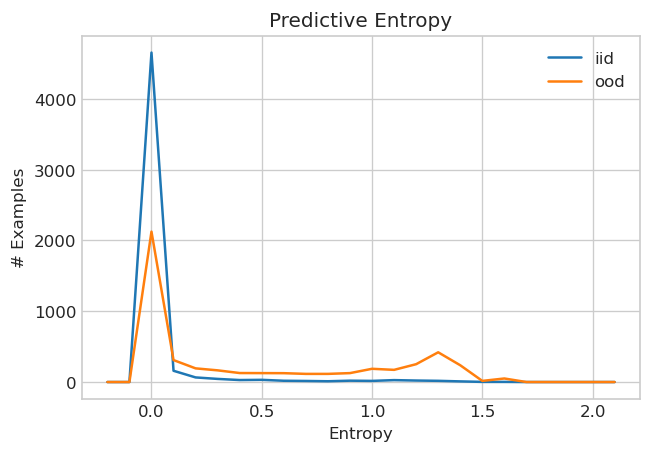

In [28]:
plot_pred_entropy_hist_two(ENTROPY=ENTROPY,
                       title=f"Predictive Entropy")

#### DE5 Models

In [29]:
# run = wandb.init(name=f'seed {seed}', project="DEModel", group='DE1Model', entity="rami-ahmed")
de5_model = DEModel(n_models=5, input_size=input_size, n_classes=n_classes,
                    net_arch=net_arch, lr=learning_rate,
                    pl_logger=None, adv_train=False, device=device, seed=seed)
de5_model.train_Model(mnist_dm_iid, n_epochs=n_epochs)

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-package

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [30]:
INFO['iid']['Ensemble']['5'] = de5_model.test_Model(mnist_dm_iid, entropy=True, reliability=False)
INFO['ood']['Ensemble']['5'] = de5_model.test_Model(mnist_dm_ood, entropy=True, reliability=False)
ENTROPY = [INFO['iid']['Ensemble']['5']['entropy'], INFO['ood']['Ensemble']['5']['entropy']]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.270182341337204,
 'test_acc': 0.9780113101005554,
 'test_loss_ce': 0.12722402811050415,
 'test_loss_nll': 0.12722404301166534}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.8904241323471069,
 'test_acc': 0.0,
 'test_loss_ce': 13.2798433303833,
 'test_loss_nll': 13.2798433303833}
--------------------------------------------------------------------------------



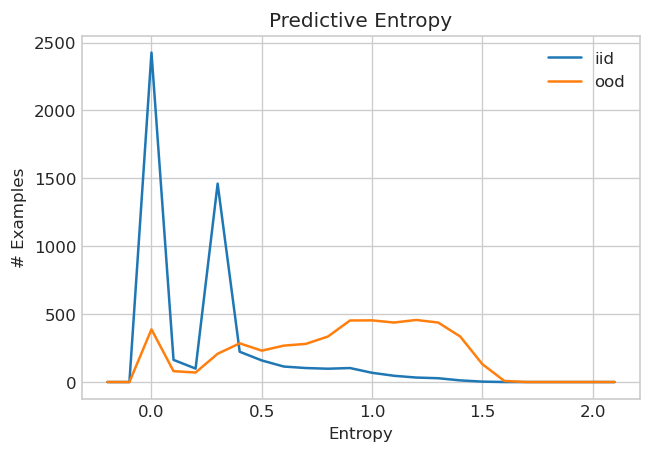

In [31]:
plot_pred_entropy_hist_two(ENTROPY=ENTROPY,
                           title=f"Predictive Entropy")

#### DE10 Models

In [32]:
de10_model = DEModel(n_models=10, input_size=input_size, n_classes=n_classes,
                     net_arch=net_arch, lr=learning_rate,
                     device=device, seed=seed)
de10_model.train_Model(mnist_dm_iid, n_epochs=n_epochs)

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-package

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [33]:
INFO['iid']['Ensemble']['10'] = de10_model.test_Model(mnist_dm_iid, entropy=True, reliability=False)
INFO['ood']['Ensemble']['10'] = de10_model.test_Model(mnist_dm_ood, entropy=True, reliability=False)
INFO['mix']['Ensemble']['10'] = de10_model.test_Model(mnist_dm, entropy=False, reliability=True)
ENTROPY = [INFO['iid']['Ensemble']['10']['entropy'], INFO['ood']['Ensemble']['10']['entropy']]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.33281534910202026,
 'test_acc': 0.9774275422096252,
 'test_loss_ce': 0.13887257874011993,
 'test_loss_nll': 0.13887257874011993}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.9784053564071655,
 'test_acc': 0.0,
 'test_loss_ce': 11.614151954650879,
 'test_loss_nll': 11.614151954650879}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5023000240325928,
 'test_loss_ce': 5.717006206512451,
 'test_loss_nll': 5.717006206512451}
--------------------------------------------------------------------------------



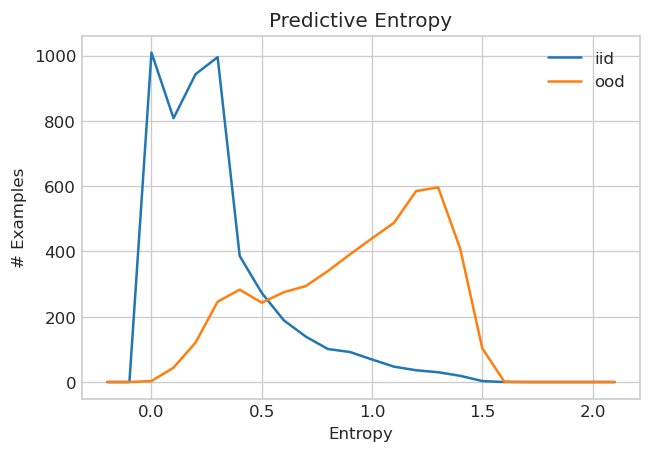

In [34]:
plot_pred_entropy_hist_two(ENTROPY=ENTROPY,
                       title=f"Predictive Entropy")

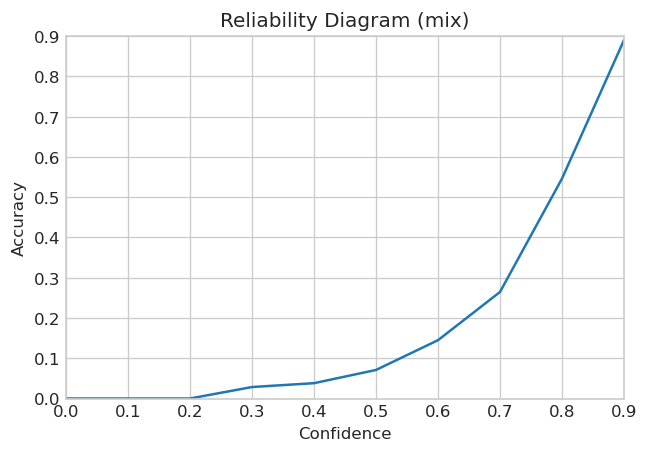

In [35]:
plot_reliability(reliability=INFO['mix']['Ensemble']['10']['reliability'],
                 title=f'Reliability Diagram (mix)')

### Deep Ensemble Models + Adversarial Training

In [36]:
seed = 0
n_epochs = 10

#### DE1 Model

In [37]:
de1_at_model = DEModel(n_models=1, input_size=input_size, n_classes=n_classes,
                       net_arch=net_arch, lr=learning_rate,
                       pl_logger=None, adv_train=True, device=device, seed=seed)
de1_at_model.train_Model(mnist_dm_iid, n_epochs=n_epochs)

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-package

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [38]:
INFO['iid']['Ensemble+AT']['1'] = de1_at_model.test_Model(mnist_dm_iid, entropy=True, reliability=False)
INFO['ood']['Ensemble+AT']['1'] = de1_at_model.test_Model(mnist_dm_ood, entropy=True, reliability=False)
ENTROPY = [INFO['iid']['Ensemble+AT']['1']['entropy'], INFO['ood']['Ensemble+AT']['1']['entropy']]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.1147608831524849,
 'test_acc': 0.9752870202064514,
 'test_loss_ce': 0.10984516888856888,
 'test_loss_nll': 0.10984515398740768}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.573925793170929,
 'test_acc': 0.0,
 'test_loss_ce': 21.816450119018555,
 'test_loss_nll': 21.816450119018555}
--------------------------------------------------------------------------------



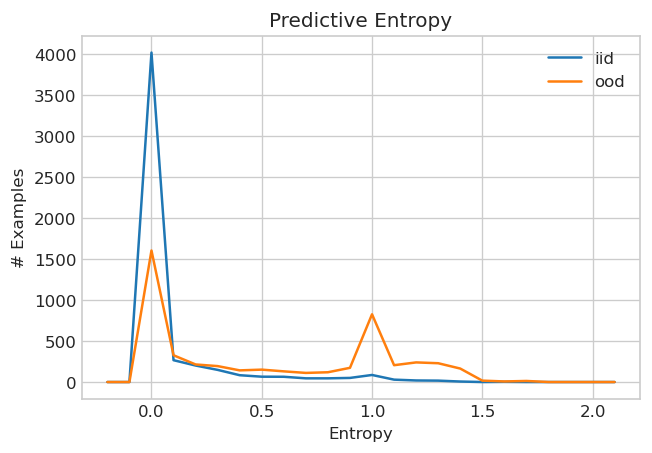

In [39]:
plot_pred_entropy_hist_two(ENTROPY=ENTROPY,
                       title=f"Predictive Entropy")

#### DE5 Models

In [40]:
de5_at_model = DEModel(n_models=5, input_size=input_size, n_classes=n_classes,
                       net_arch=net_arch, lr=learning_rate,
                       pl_logger=None, adv_train=True, device=device, seed=seed)
de5_at_model.train_Model(mnist_dm_iid, n_epochs=n_epochs)

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-package

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [41]:
INFO['iid']['Ensemble+AT']['5'] = de5_at_model.test_Model(mnist_dm_iid, entropy=True, reliability=False)
INFO['ood']['Ensemble+AT']['5'] = de5_at_model.test_Model(mnist_dm_ood, entropy=True, reliability=False)
ENTROPY = [INFO['iid']['Ensemble+AT']['5']['entropy'], INFO['ood']['Ensemble+AT']['5']['entropy']]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.3015765845775604,
 'test_acc': 0.9766491651535034,
 'test_loss_ce': 0.13523031771183014,
 'test_loss_nll': 0.13523028790950775}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.9533859491348267,
 'test_acc': 0.0,
 'test_loss_ce': 11.24394702911377,
 'test_loss_nll': 11.24394702911377}
--------------------------------------------------------------------------------



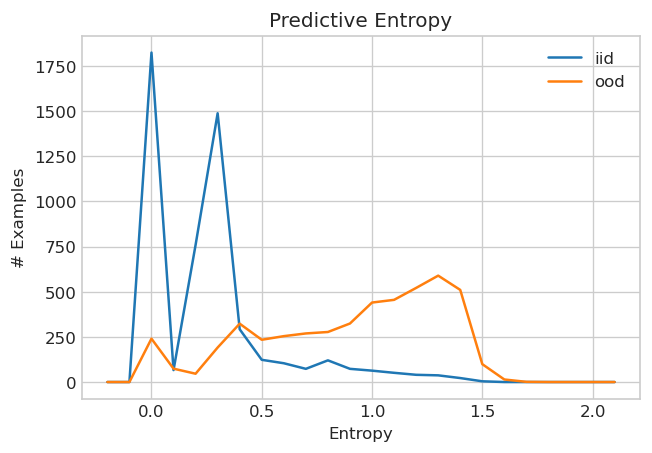

In [42]:
plot_pred_entropy_hist_two(ENTROPY=ENTROPY,
                       title=f"Predictive Entropy")

#### DE10 Models

In [43]:
de10_at_model = DEModel(n_models=10, input_size=input_size, n_classes=n_classes,
                        net_arch=net_arch, lr=learning_rate,
                        pl_logger=None, adv_train=True, device=device, seed=seed)
de10_at_model.train_Model(mnist_dm_iid, n_epochs=n_epochs)

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-package

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [44]:
INFO['iid']['Ensemble+AT']['10'] = de10_at_model.test_Model(mnist_dm_iid, entropy=True, reliability=False)
INFO['ood']['Ensemble+AT']['10'] = de10_at_model.test_Model(mnist_dm_ood, entropy=True, reliability=False)
INFO['mix']['Ensemble+AT']['10'] = de10_at_model.test_Model(mnist_dm, entropy=False, reliability=True)
ENTROPY = [INFO['iid']['Ensemble+AT']['10']['entropy'], INFO['ood']['Ensemble+AT']['10']['entropy']]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.3516158163547516,
 'test_acc': 0.9752870202064514,
 'test_loss_ce': 0.14461906254291534,
 'test_loss_nll': 0.14461904764175415}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 1.0045260190963745,
 'test_acc': 0.0,
 'test_loss_ce': 10.906646728515625,
 'test_loss_nll': 10.906645774841309}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5012000203132629,
 'test_loss_ce': 5.376040458679199,
 'test_loss_nll': 5.376040458679199}
--------------------------------------------------------------------------------



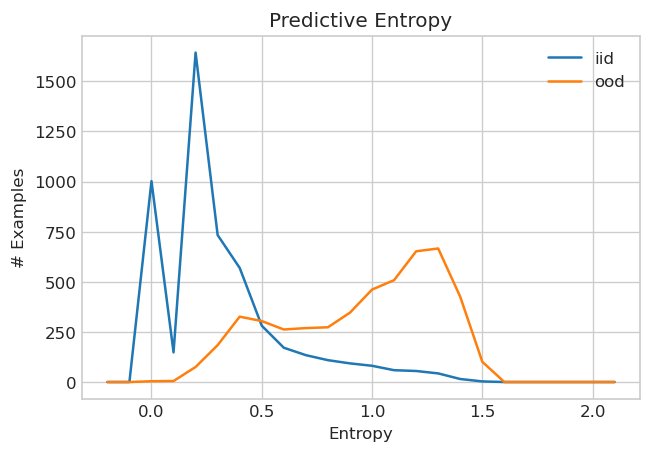

In [45]:
plot_pred_entropy_hist_two(ENTROPY=ENTROPY,
                           title=f"Predictive Entropy")

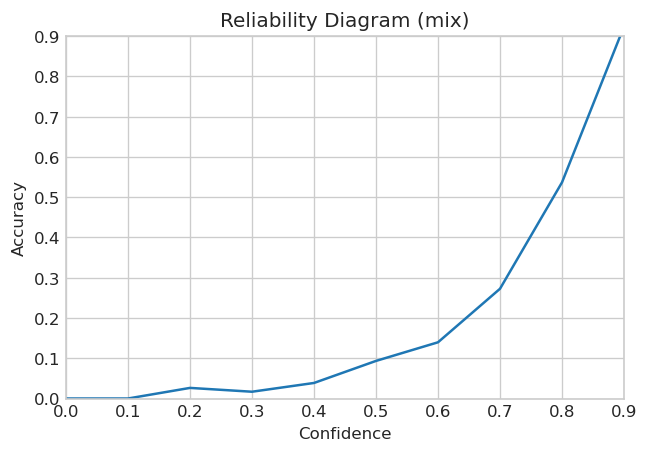

In [46]:
plot_reliability(reliability=INFO['mix']['Ensemble+AT']['10']['reliability'],
                 title='Reliability Diagram (mix)')

### MC Dropout Models Training ( do=0.1 )

In [47]:
seed = 0
n_epochs = 10

#### AVG1 (No avgeraging)

In [48]:
mcdo1_model = MCDOModel(input_size=input_size, n_classes=n_classes,
                        net_arch=net_arch, lr=learning_rate,
                        pl_logger=None, dropout=0.1, avg=1, device=device, seed=seed)
mcdo1_model.train_Model(mnist_dm_iid, n_epochs=n_epochs)

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-package

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [49]:
INFO['iid']['MC Dropot']['1'] = mcdo1_model.test_Model(mnist_dm_iid, entropy=True, reliability=False)
INFO['ood']['MC Dropot']['1'] = mcdo1_model.test_Model(mnist_dm_ood, entropy=True, reliability=False)
ENTROPY = [INFO['iid']['MC Dropot']['1']['entropy'], INFO['ood']['MC Dropot']['1']['entropy']]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.27530816197395325,
 'test_acc': 0.9153531789779663,
 'test_loss_nll': 0.3195865750312805}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.6633532047271729,
 'test_acc': 0.0,
 'test_loss_nll': 49.5679817199707}
--------------------------------------------------------------------------------



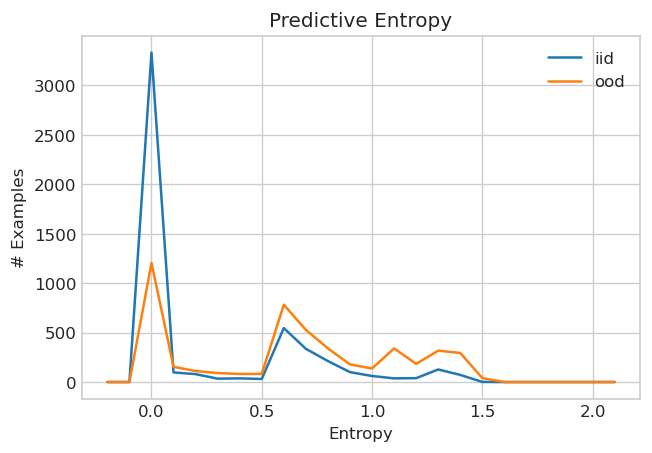

In [50]:
plot_pred_entropy_hist_two(ENTROPY=ENTROPY,
                       title=f"Predictive Entropy")

#### AVG5

In [51]:
mcdo5_model = MCDOModel(input_size=input_size, n_classes=n_classes,
                        net_arch=net_arch, lr=learning_rate,
                        pl_logger=None, dropout=0.1, avg=5, device=device, seed=seed)
mcdo5_model.train_Model(mnist_dm_iid, n_epochs=n_epochs)

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-package

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [52]:
INFO['iid']['MC Dropot']['5'] = mcdo5_model.test_Model(mnist_dm_iid, entropy=True, reliability=False)
INFO['ood']['MC Dropot']['5'] = mcdo5_model.test_Model(mnist_dm_ood, entropy=True, reliability=False)
ENTROPY = [INFO['iid']['MC Dropot']['5']['entropy'], INFO['ood']['MC Dropot']['5']['entropy']]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.37384822964668274,
 'test_acc': 0.9624440670013428,
 'test_loss_nll': 0.2120019793510437}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.780424952507019,
 'test_acc': 0.0,
 'test_loss_nll': 16.00234031677246}
--------------------------------------------------------------------------------



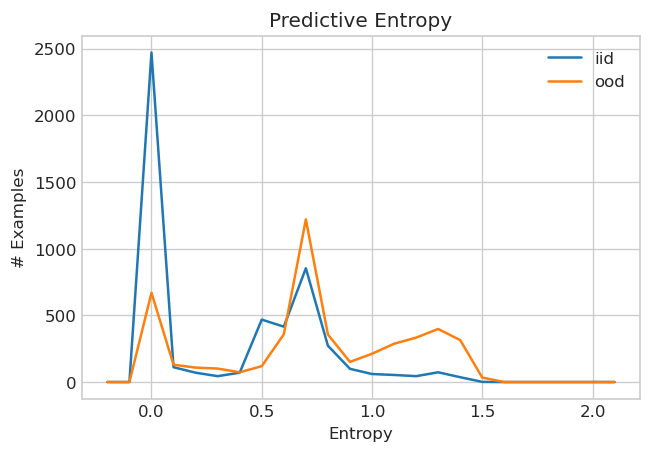

In [53]:
plot_pred_entropy_hist_two(ENTROPY=ENTROPY,
                       title=f"Predictive Entropy")

#### AVG10

In [54]:
mcdo10_model = MCDOModel(input_size=input_size, n_classes=n_classes,
                        net_arch=net_arch, lr=learning_rate,
                        pl_logger=None, dropout=0.1, avg=10, device=device, seed=seed)
mcdo10_model.train_Model(mnist_dm_iid, n_epochs=n_epochs)

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/rami/anaconda3/envs/PT/lib/python3.8/site-package

/Users/rami/anaconda3/envs/PT/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [55]:
INFO['iid']['MC Dropot']['10'] = mcdo10_model.test_Model(mnist_dm_iid, entropy=True, reliability=False)
INFO['ood']['MC Dropot']['10'] = mcdo10_model.test_Model(mnist_dm_ood, entropy=True, reliability=False)
INFO['mix']['MC Dropot']['10'] = mcdo10_model.test_Model(mnist_dm, entropy=False, reliability=True)
ENTROPY = [INFO['iid']['MC Dropot']['10']['entropy'], INFO['ood']['MC Dropot']['10']['entropy']]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.40100839734077454,
 'test_acc': 0.9647791385650635,
 'test_loss_nll': 0.20522646605968475}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_entropy': 0.7953579425811768,
 'test_acc': 0.0,
 'test_loss_nll': 14.332763671875}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.49630001187324524, 'test_loss_nll': 7.044698238372803}
--------------------------------------------------------------------------------



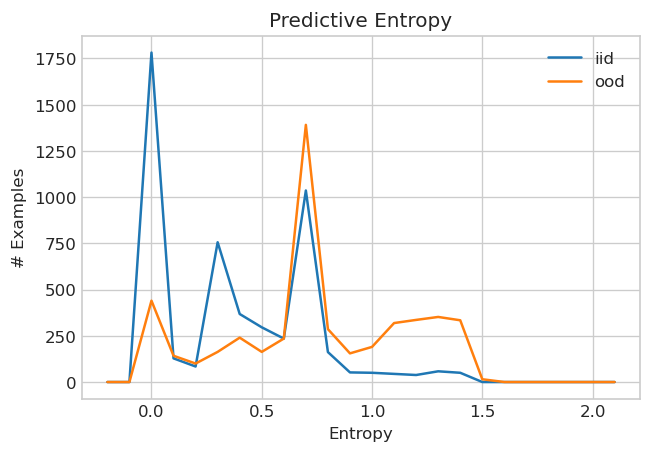

In [56]:
plot_pred_entropy_hist_two(ENTROPY=ENTROPY,
                           title=f"Predictive Entropy")

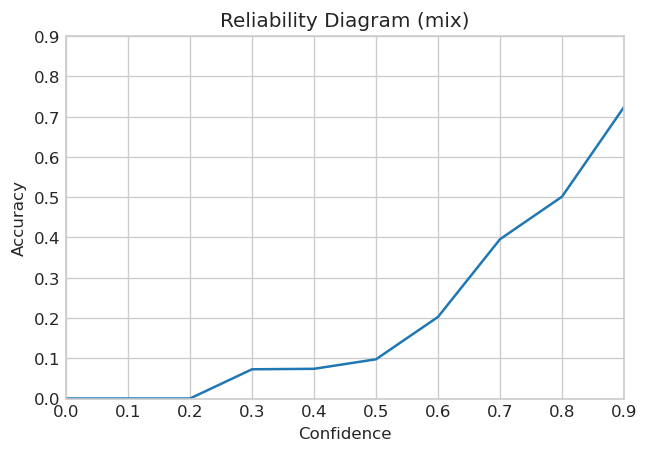

In [57]:
plot_reliability(reliability=INFO['mix']['MC Dropot']['10']['reliability'],
                 title='Reliability Diagram (mix)')

### Task I: Uncertainty evaluation: test examples from known (iid) vs unknown (ood) classes

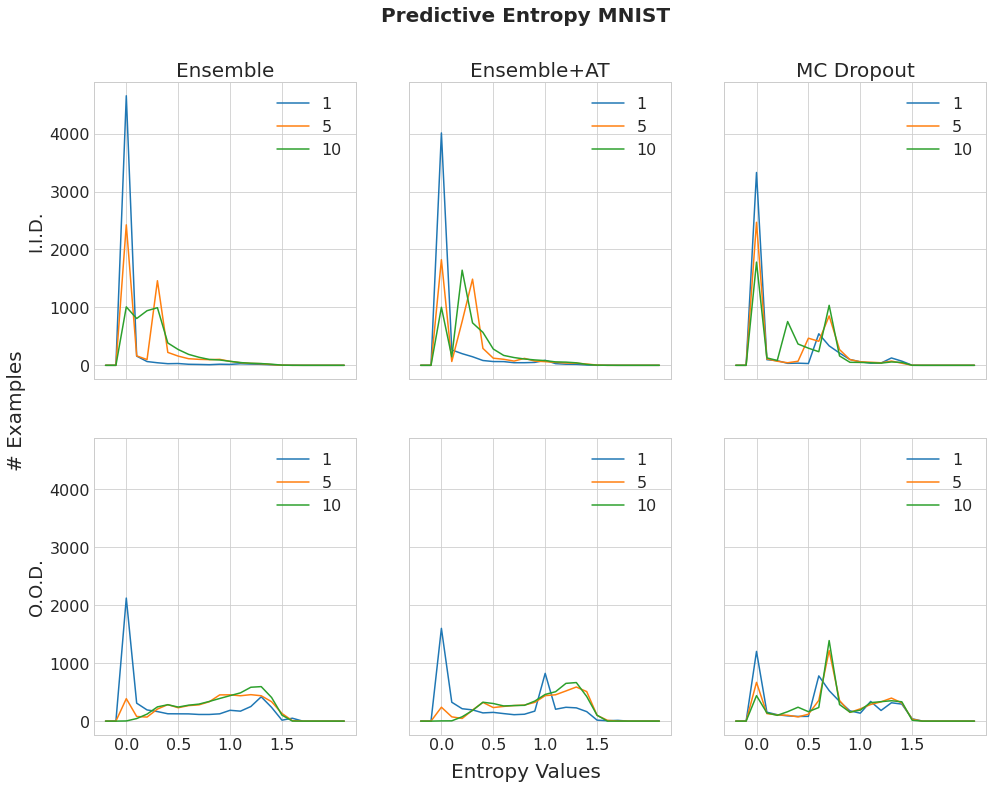

In [58]:
plot_pred_entropy_hist_multi(INFO, title="Predictive Entropy")

### Task II: Accuracy as a function of confidence (Reliability Diagram) | Model 10

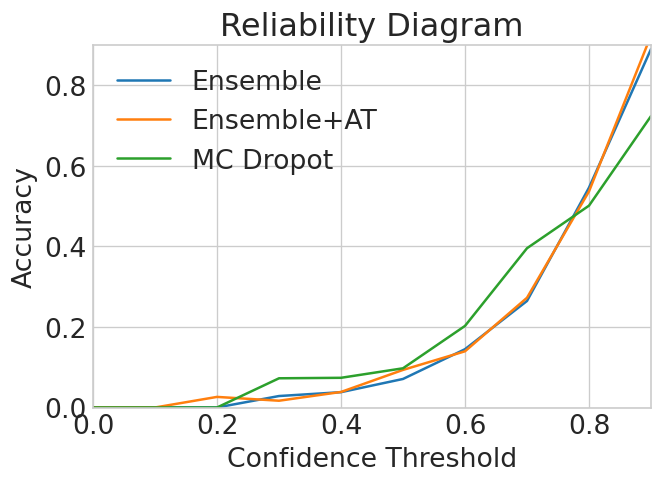

In [59]:
plot_reliability_multi(INFO, title='Reliability Diagram')

### Extra Tasks

In [ ]:
# TODO: Ensembles + MC Dropout

In [ ]:
# TODO: MC Dropout + Adversarial Training

In [ ]:
# TODO: Ensembles + Adversarial Training + MC Dropout